# imports and constants

In [1]:
import requests
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM

IRISH_POETRY = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt"

# gather the data and split into scentences

In [2]:
def request_data(dataset_url):
    # send the get request to the server
    response = requests.get(dataset_url)
    # convert the response to text format
    datastore = response.text
    return datastore

def read_data(dataset_url):
    # get the datastore itself
    datastore = request_data(dataset_url)
    # convert and split the data
    datastore = datastore.lower().split("\n")
    return datastore

datastore = read_data(IRISH_POETRY)

# create a tokenizer on the words in the dataset

In [3]:
def get_tokenizer(datastore):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer
    tokenizer.fit_on_texts(datastore)
    # get the total number of words, add one for the oov token
    total_words = len(tokenizer.word_index) + 1
    return tokenizer, total_words

tokenizer, total_words = get_tokenizer(datastore)

# transform scentences to sequences

In [4]:
def sentences_to_sequences(tokenizer, sentences):
    # initialize the input sequences array
    input_sequences = []
    # iterate over the lines in the sentences
    for line in sentences:
        # get the token list for this line
        token_list = tokenizer.texts_to_sequences([line])[0]
        # iterate i from 1 to the total length of the tokenized list
        for i in range(1, len(token_list)):
            # create a sequence from the start of the sequence until the i-th entry in the sequence
            n_gram_sequence = token_list[:i+1]
            # append this n_gram_sequence to the input_sequences list
            input_sequences.append(n_gram_sequence)
    # get the length of the longest input sequence in the list
    max_sequence_len = max([len(x) for x in input_sequences])
    return input_sequences, max_sequence_len

def pad_input_sequences(input_sequences, max_length):
    # pad the sequences in the input list
    padded_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='pre')
    # convert this list to a numpy array
    padded_sequences = np.array(padded_sequences)
    return padded_sequences

input_sequences, max_sequence_len = sentences_to_sequences(tokenizer, datastore)
padded_sequences = pad_input_sequences(input_sequences, max_sequence_len)

# convert the data to data for the model

In [5]:
def data_to_train_data(input_sequences, total_words):
    # get all the words leading up to the last word
    xs = input_sequences[:, :-1]
    # get the last word in every sequence
    labels = input_sequences[:, -1]
    # transform these labels into categories
    ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
    return xs, ys

xs, ys = data_to_train_data(padded_sequences, total_words)

# create the model for our uses

In [6]:
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 240, input_length=max_sequence_len - 1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(total_words, max_sequence_len)

# train the model on the input data

In [7]:
def train_model(model, xs, ys):
    hist = model.fit(xs, ys, epochs=50, verbose=1)
    return hist

hist = train_model(model, xs, ys)

Epoch 1/50
377/377 [==============================] - 18s 40ms/step - loss: 6.9700 - accuracy: 0.0593
Epoch 2/50
377/377 [==============================] - 13s 35ms/step - loss: 6.2117 - accuracy: 0.0773
Epoch 3/50
377/377 [==============================] - 13s 34ms/step - loss: 5.8799 - accuracy: 0.0919
Epoch 4/50
377/377 [==============================] - 13s 34ms/step - loss: 5.5330 - accuracy: 0.1140
Epoch 5/50
377/377 [==============================] - 13s 35ms/step - loss: 5.0773 - accuracy: 0.1330
Epoch 6/50
377/377 [==============================] - 13s 34ms/step - loss: 4.6838 - accuracy: 0.1613
Epoch 7/50
377/377 [==============================] - 13s 34ms/step - loss: 4.3298 - accuracy: 0.1923
Epoch 8/50
377/377 [==============================] - 13s 34ms/step - loss: 3.9119 - accuracy: 0.2409
Epoch 9/50
377/377 [==============================] - 13s 34ms/step - loss: 3.5411 - accuracy: 0.2962
Epoch 10/50
377/377 [==============================] - 15s 40ms/step - loss: 3.203

# graph the training results

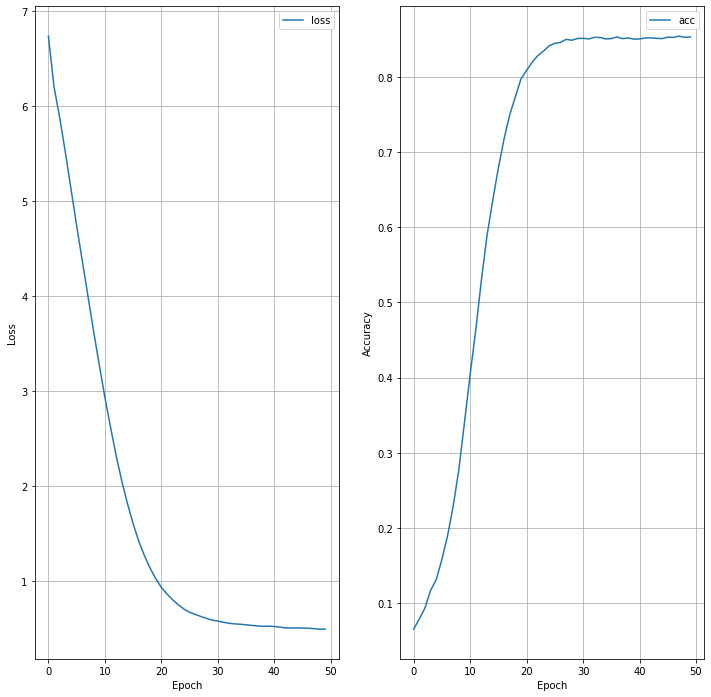

In [9]:
def graph_results(hist):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(12, 12))
    epochs = hist.epoch
    loss = hist.history['loss']
    acc = hist.history['accuracy']
    axs[0].plot(epochs, loss, label='loss')
    axs[1].plot(epochs, acc, label='acc')
    axs[0].grid(True, which='both', axis='both')
    axs[1].grid(True, which='both', axis='both')
    axs[0].set_ylabel('Loss')
    axs[1].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].legend()
    axs[1].legend()
    fig.savefig("C:\\Users\\kiern\\MyFolders\\Code\\GitRepositories\\Natural-Language-Processing-Text-Generation\\results.png")
    plt.show()
    return

graph_results(hist)

# generate new text using the trained model

In [11]:
def generate_text(model, tokenizer, max_sequence_len, next_words=50):
    seed_text = "I made a poetry machine"
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if(index == predicted):
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return

generate_text(model, tokenizer, max_sequence_len)

I made a poetry machine way for a soldier boy to the town of toome today today and toome today of gone doves gone and ones they eyes of my eyes of night unseen each wind by here and high gone and they steal your eyes are green who no more young sea more rest
